# Prophet Model

The objective of this notebook is to run multiple experiments with Prophet model on KRS water data. We will use time-series cross-validation to evaluate the performance of the model.

## Load Packages

In [1]:
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

## Dataset

In [2]:
df = pd.read_csv("./Data/KRS_cleaned_linear_interpolation.csv", index_col=['FLOW_DATE'], parse_dates=['FLOW_DATE'])
df = df.fillna(method='ffill')
df['MONTH_NO'] = df.index.month

In [3]:
df

,SL_NO,RESERVOIR,YEAR,WEEK_NO,PRESENT_STORAGE_TMC,RES_LEVEL_FT,INFLOW_CUSECS,OUTFLOW_CUECS,UNIQUE_KEY,MONTH_NO
FLOW_DATE,,,,,,,,,,
2011-01-01,51.0,K.R.S,2011.0,1.0,46.42,122.59,2029.0,2000.0,K.R.S-2011-01-01,1
2011-01-02,52.0,K.R.S,2011.0,1.0,46.54,122.68,3084.0,1490.0,K.R.S-2011-01-02,1
2011-01-03,53.0,K.R.S,2011.0,1.0,46.64,122.75,2776.0,1491.0,K.R.S-2011-01-03,1
2011-01-04,54.0,K.R.S,2011.0,1.0,46.69,122.79,2311.0,1491.0,K.R.S-2011-01-04,1
2011-01-05,55.0,K.R.S,2011.0,1.0,46.70,122.80,1847.0,1491.0,K.R.S-2011-01-05,1
...,...,...,...,...,...,...,...,...,...,...
2020-12-12,43915.0,K.R.S,2020.0,50.0,43.04,120.00,3496.0,3308.0,K.R.S-2020-12-12,12
2020-12-13,43916.0,K.R.S,2020.0,50.0,43.02,119.98,3197.0,3300.0,K.R.S-2020-12-13,12
2020-12-14,43917.0,K.R.S,2020.0,50.0,42.98,119.95,3026.0,3273.0,K.R.S-2020-12-14,12


In [4]:
dataset = df[['RES_LEVEL_FT', 'INFLOW_CUSECS', 'OUTFLOW_CUECS', 'WEEK_NO', 'MONTH_NO']].reset_index()
dataset.head(5)

,FLOW_DATE,RES_LEVEL_FT,INFLOW_CUSECS,OUTFLOW_CUECS,WEEK_NO,MONTH_NO
0,2011-01-01,122.59,2029.0,2000.0,1.0,1
1,2011-01-02,122.68,3084.0,1490.0,1.0,1
2,2011-01-03,122.75,2776.0,1491.0,1.0,1
3,2011-01-04,122.79,2311.0,1491.0,1.0,1
4,2011-01-05,122.80,1847.0,1491.0,1.0,1


## Visualization

<AxesSubplot:xlabel='FLOW_DATE'>

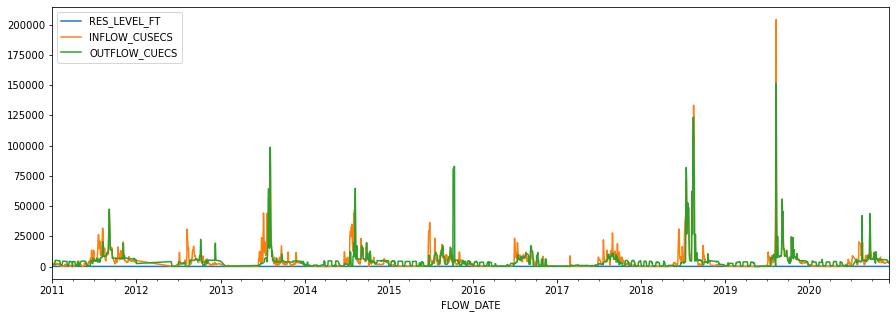

In [5]:
fig, ax = plt.subplots(figsize=(15, 5))
df[['RES_LEVEL_FT', 'INFLOW_CUSECS', 'OUTFLOW_CUECS']].plot(ax=ax)

## Modeling

In [6]:
def cross_validate_model(model, dataset, time_col, y, external_regressors=None):
    if external_regressors is None:
        y_train = dataset[[time_col, y]].rename(columns = {time_col: 'ds', y: 'y'})
    else:
        y_train = dataset[[time_col, y] + external_regressors].rename(columns = {time_col: 'ds', y: 'y'})
        
        for regressor in external_regressors:
            model.add_regressor(regressor)
    
    model.fit(y_train)
            
    cv_results = cross_validation(model, initial = '3000days', period = '50days', horizon='90days')
    cv_performance = performance_metrics(cv_results)
    
    return(cv_results, cv_performance)

def train_model(model, dataset, time_col, y, external_regressors=None, test_length=90):
    dataset_train = dataset[:-test_length]
    dataset_test = dataset[-test_length:]
    
    if external_regressors is None:
        y_train = dataset_train[[time_col, y]].rename(columns = {time_col: 'ds', y: 'y'})
        y_test = dataset_test[[time_col, y]].rename(columns = {time_col: 'ds', y: 'y'})
    else:
        y_train = dataset_train[[time_col, y] + external_regressors].rename(columns = {time_col: 'ds', y: 'y'})
        y_test = dataset_test[[time_col, y] + external_regressors].rename(columns = {time_col: 'ds', y: 'y'})
        
        for regressor in external_regressors:
            model.add_regressor(regressor)
            
    model.fit(y_train)
    forecast = model.predict(y_test)
    
    forecast_df = pd.DataFrame({
        'Actual': dataset_test[y].values,
        'Forecasted': forecast['yhat'].values
    }, index=dataset_test[time_col])
    
    fitted = model.predict(y_train)
    
    fitted_df = pd.DataFrame({
        'Actual': dataset_train[y].values,
        'Fitted': fitted['yhat'].values
    }, index=dataset_train[time_col])
    
    return model, forecast_df, fitted_df, dataset_train, dataset_test

def model_evaluation(values_df, error_metric, predicted_column, actual_column):
    return round(error_metric(y_pred=values_df[predicted_column].values, y_true=values_df[actual_column]), 2)

### Model 1

Independent Variables:
* 'RES_LEVEL_FT'

#### Cross-Validation

In [7]:
cv_results, cv_performance = cross_validate_model(Prophet(), dataset, 'FLOW_DATE', 'RES_LEVEL_FT')

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 11 forecasts with cutoffs between 2019-05-06 00:00:00 and 2020-09-17 00:00:00


Initial log joint probability = -86.7154
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       8368.63    0.00754543       674.299       0.485       0.485      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       8512.82     0.0160205       1067.53       0.486           1      242   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       8554.19      0.012357        245.42           1           1      359   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       8571.18    0.00409332       651.182      0.3457           1      488   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        8583.6     0.0140182       291.571      0.7056      0.7056      609   
    Iter      log prob        ||dx||      ||grad||       alpha  

  0%|          | 0/11 [00:00<?, ?it/s]

Initial log joint probability = -41.1958
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       7050.71      0.158438       2574.73           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       7262.94      0.100487       547.015      0.8956     0.08956      233   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     271       7307.89   0.000601474       304.185   1.688e-06       0.001      358  LS failed, Hessian reset 
     299       7317.29    0.00128252        384.68      0.7648      0.7648      395   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       7357.64    0.00133281        298.78      0.7916      0.7916      507   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       7387.84     0.0178071    

Initial log joint probability = -94.3853
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       7003.85      0.222183       384.572           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       7189.47     0.0951885       259.504           1           1      236   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       7216.83     0.0021677       127.108        2.41       0.241      357   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       7227.14    0.00143021       135.559      0.5739      0.5739      477   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       7238.03   0.000768501       98.7459           1           1      600   
    Iter      log prob        ||dx||      ||grad||       alpha  

Initial log joint probability = -87.1432
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       7381.38     0.0220051       674.328           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       7566.78     0.0236425       334.024      0.5046           1      252   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        7608.1     0.0262893       829.833           1           1      366   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        7642.5    0.00181803       1047.08     0.01171     0.05123      489   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       7662.41    0.00638184       537.755      0.9962      0.9962      612   
    Iter      log prob        ||dx||      ||grad||       alpha  

Initial log joint probability = -55.9178
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       7716.27       0.15333        3679.6           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       7896.74     0.0335966       2530.86      0.3686           1      236   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       7930.85    0.00363688       233.271           1           1      348   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       7981.05    0.00174236       240.578           1           1      455   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       8008.21     0.0014271       407.812           1           1      571   
    Iter      log prob        ||dx||      ||grad||       alpha  

Initial log joint probability = -98.6196
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       8041.23     0.0430624       1255.83      0.8106     0.08106      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       8209.21    0.00953228       668.183       0.304           1      233   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        8322.4    0.00638059       1060.79           1           1      345   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     369       8343.01   0.000115851       221.277   3.159e-07       0.001      476  LS failed, Hessian reset 
     399       8359.11    0.00541566       441.361      0.8333      0.8333      512   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        8375.8    0.00612138    

/opt/homebrew/Caskroom/miniforge/base/envs/hackathon/lib/python3.9/site-packages/prophet/plot.py:539: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])
/opt/homebrew/Caskroom/miniforge/base/envs/hackathon/lib/python3.9/site-packages/prophet/plot.py:540: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])


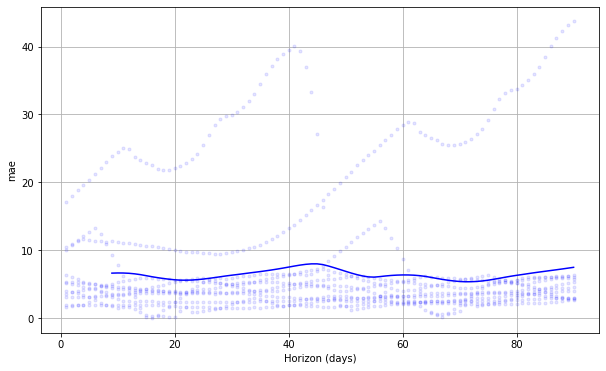

In [8]:
p = plot_cross_validation_metric(cv_results, 'mae')

/opt/homebrew/Caskroom/miniforge/base/envs/hackathon/lib/python3.9/site-packages/prophet/plot.py:539: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])
/opt/homebrew/Caskroom/miniforge/base/envs/hackathon/lib/python3.9/site-packages/prophet/plot.py:540: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])


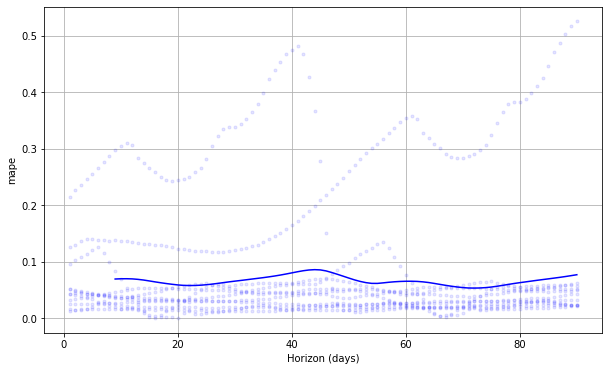

In [9]:
p = plot_cross_validation_metric(cv_results, 'mape')

#### Training

In [10]:
model1, model1_forecast, model1_fitted, _, _ = train_model(Prophet(), dataset, 'FLOW_DATE', 'RES_LEVEL_FT')

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -98.6196
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       8041.23     0.0430624       1255.83      0.8106     0.08106      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       8209.21    0.00953228       668.183       0.304           1      233   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        8322.4    0.00638059       1060.79           1           1      345   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     369       8343.01   0.000115851       221.277   3.159e-07       0.001      476  LS failed, Hessian reset 
     399       8359.11    0.00541566       441.361      0.8333      0.8333      512   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        8375.8    0.00612138    

#### Evaluation

##### Train Set

<AxesSubplot:xlabel='FLOW_DATE'>

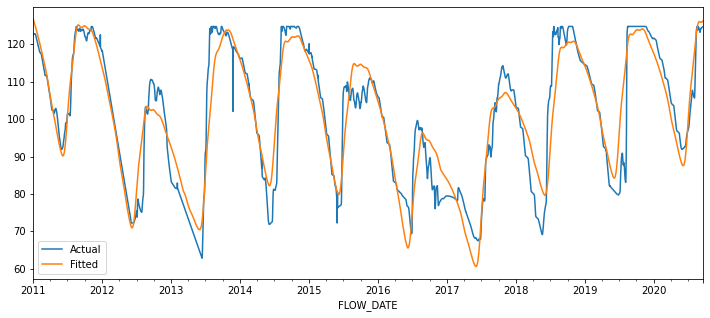

In [11]:
model1_fitted.plot(figsize=(12, 5))

In [12]:
model_evaluation(model1_fitted, mean_absolute_error, 'Fitted', 'Actual')

4.58

In [13]:
model_evaluation(model1_fitted, mean_absolute_percentage_error, 'Fitted', 'Actual')

0.05

##### Test Set

<AxesSubplot:xlabel='FLOW_DATE'>

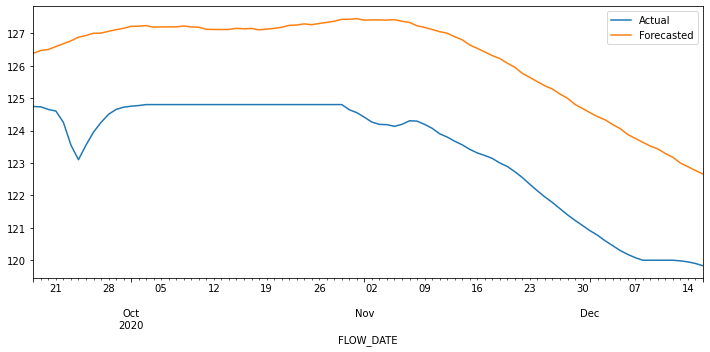

In [14]:
model1_forecast.plot(figsize=(12, 5))

In [15]:
model_evaluation(model1_forecast, mean_absolute_error, 'Forecasted', 'Actual')

2.9

In [16]:
model_evaluation(model1_forecast, mean_absolute_percentage_error, 'Forecasted', 'Actual')

0.02

### Model 2

Independent Variables:
* RES_LEVEL_FT
* INFLOW_CUSECS
* OUTFLOW_CUECS

#### Cross-Validation

In [17]:
cv_results, cv_performance = cross_validate_model(Prophet(), 
                                                  dataset, 
                                                  'FLOW_DATE', 
                                                  'RES_LEVEL_FT', 
                                                  external_regressors=['INFLOW_CUSECS', 'OUTFLOW_CUECS'])

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 11 forecasts with cutoffs between 2019-05-06 00:00:00 and 2020-09-17 00:00:00


Initial log joint probability = -86.7154
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       8345.55    0.00433303        789.17           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       8512.55     0.0111756        937.83           1           1      223   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       8626.17    0.00628982       991.396      0.1707           1      329   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       8653.46     0.0139212        764.25           1           1      442   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       8667.43    0.00659913       494.444           1           1      554   
    Iter      log prob        ||dx||      ||grad||       alpha  

  0%|          | 0/11 [00:00<?, ?it/s]

Initial log joint probability = -41.1958
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       7056.93     0.0237408       1804.76           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       7313.35     0.0121997       714.006           1           1      226   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       7355.39     0.0282881       1552.56           1           1      332   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       7434.21    0.00318919       790.075      0.6619      0.6619      441   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       7471.86    0.00146826       361.171       0.899       0.899      556   
    Iter      log prob        ||dx||      ||grad||       alpha  

Initial log joint probability = -94.3853
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       7044.35    0.00426245        2974.7      0.3771      0.3771      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       7257.49    0.00402715       382.659      0.8931      0.8931      230   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       7299.57     0.0262404       1453.87      0.5031      0.5031      343   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       7322.41    0.00592895       731.045           1           1      456   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        7344.5   0.000678242       162.873       1.432      0.1432      568   
    Iter      log prob        ||dx||      ||grad||       alpha  

Initial log joint probability = -87.1432
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       7443.41    0.00529783       1382.79      0.2369           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       7592.62    0.00291281       372.878           1           1      228   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       7674.63    0.00461499       383.635      0.9214      0.9214      340   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       7731.48   0.000709368       167.002           1           1      454   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       7756.65    0.00545769       589.798           1           1      572   
    Iter      log prob        ||dx||      ||grad||       alpha  

Initial log joint probability = -55.9178
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       7744.05     0.0158794       1566.76           1           1      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       7942.55     0.0163728       1719.53      0.4867           1      220   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       8015.47    0.00249471       179.007           1           1      329   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       8062.26    0.00173028       633.627           1           1      437   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       8093.36    0.00132951       181.423           1           1      548   
    Iter      log prob        ||dx||      ||grad||       alpha  

Initial log joint probability = -62.0836
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       8006.72     0.0048542       394.955           1           1      105   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       8184.18    0.00689928       511.702      0.2332           1      217   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       8276.82     0.0231091       1236.02           1           1      327   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       8307.79    0.00244819       495.674      0.6499      0.6499      436   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       8325.37     0.0230654       613.386      0.9361      0.9361      552   
    Iter      log prob        ||dx||      ||grad||       alpha  

/opt/homebrew/Caskroom/miniforge/base/envs/hackathon/lib/python3.9/site-packages/prophet/plot.py:539: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])
/opt/homebrew/Caskroom/miniforge/base/envs/hackathon/lib/python3.9/site-packages/prophet/plot.py:540: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])


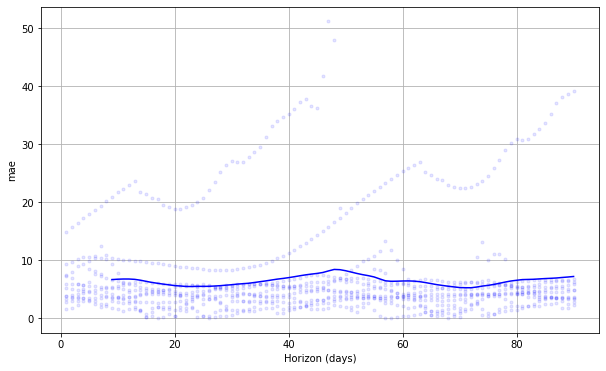

In [18]:
p = plot_cross_validation_metric(cv_results, 'mae')

/opt/homebrew/Caskroom/miniforge/base/envs/hackathon/lib/python3.9/site-packages/prophet/plot.py:539: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])
/opt/homebrew/Caskroom/miniforge/base/envs/hackathon/lib/python3.9/site-packages/prophet/plot.py:540: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])


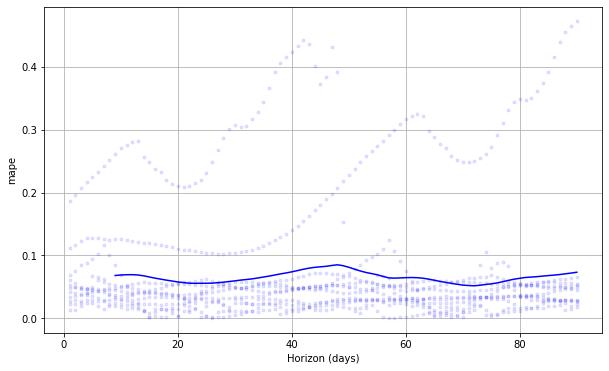

In [19]:
p = plot_cross_validation_metric(cv_results, 'mape')

#### Training

In [20]:
model2, model2_forecast, model2_fitted, _, _ = train_model(Prophet(), 
                                                           dataset, 
                                                           'FLOW_DATE', 
                                                           'RES_LEVEL_FT', 
                                                           external_regressors=['INFLOW_CUSECS', 'OUTFLOW_CUECS'])

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -98.6196
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       8118.75    0.00723345       1069.95      0.5264           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       8291.16    0.00888849       1002.65      0.9603      0.9603      228   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        8372.2    0.00445924       842.967           1           1      339   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        8424.4     0.0195204       2952.72           1           1      446   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       8485.76   0.000539006       110.909           1           1      558   
    Iter      log prob        ||dx||      ||grad||       alpha  

#### Evaluation

##### Train Set

<AxesSubplot:xlabel='FLOW_DATE'>

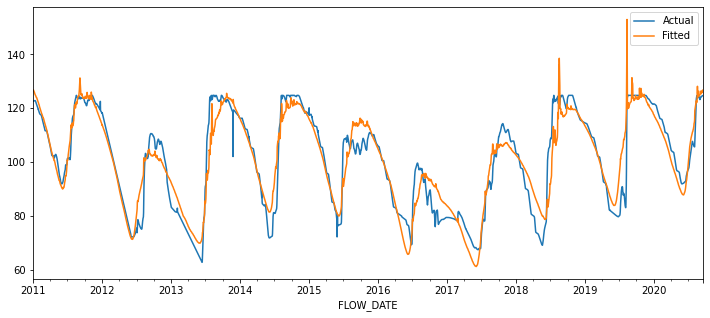

In [21]:
model2_fitted.plot(figsize=(12, 5))

In [22]:
model_evaluation(model2_fitted, mean_absolute_error, 'Fitted', 'Actual')

4.44

In [23]:
model_evaluation(model2_fitted, mean_absolute_percentage_error, 'Fitted', 'Actual')

0.05

##### Test Set

<AxesSubplot:xlabel='FLOW_DATE'>

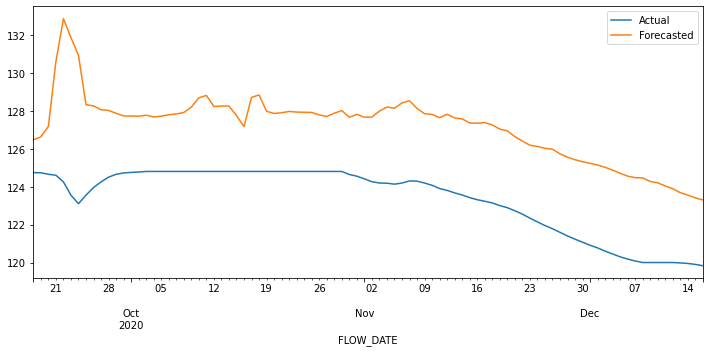

In [24]:
model2_forecast.plot(figsize=(12, 5))

In [25]:
model_evaluation(model2_forecast, mean_absolute_error, 'Forecasted', 'Actual')

3.81

In [26]:
model_evaluation(model2_forecast, mean_absolute_percentage_error, 'Forecasted', 'Actual')

0.03

### Model 3

Independent Variables:
* RES_LEVEL_FT
* INFLOW_CUSECS
* OUTFLOW_CUECS
* WEEK_NO
* MONTH_NO

In [27]:
from sklearn.preprocessing import OneHotEncoder

In [28]:
dummy_data = dataset.copy()
dummy_data['WEEK_NO'] = dummy_data['WEEK_NO'].astype(int).astype(str)
dummy_data['MONTH_NO'] = dummy_data['MONTH_NO'].astype(int).astype(str)

In [29]:
dummy_data = pd.get_dummies(dummy_data)

#### Cross-Validation

In [30]:
cv_results, cv_performance = cross_validate_model(Prophet(),
                                                  dummy_data, 
                                                  'FLOW_DATE', 
                                                  'RES_LEVEL_FT', 
                                                  external_regressors=list(dummy_data.drop(columns=['FLOW_DATE', 'RES_LEVEL_FT']).columns.values))

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 11 forecasts with cutoffs between 2019-05-06 00:00:00 and 2020-09-17 00:00:00


Initial log joint probability = -86.7154
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99          8507     0.0149214        4024.5           1           1      112   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199          8678     0.0397207       704.565           1           1      226   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       8754.89    0.00286078       468.241           1           1      337   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       8794.33    0.00180637       614.573      0.6891      0.6891      445   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       8827.93    0.00223046       190.775           1           1      557   
    Iter      log prob        ||dx||      ||grad||       alpha  

  0%|          | 0/11 [00:00<?, ?it/s]

Initial log joint probability = -41.1958
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       7198.67     0.0227268       2912.29      0.5146      0.5146      111   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       7389.24    0.00185287       638.736           1           1      217   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       7475.19    0.00495506       1655.65      0.7035      0.7035      326   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       7544.72    0.00569867        275.25           1           1      435   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       7576.15    0.00888445       586.875           1           1      540   
    Iter      log prob        ||dx||      ||grad||       alpha  

Initial log joint probability = -94.3853
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       7125.81    0.00362261       848.587           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       7363.49     0.0961581       997.565           1           1      222   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       7408.59    0.00268325       822.503      0.2565      0.2565      328   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       7437.88    0.00358797       308.034           1           1      436   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499          7451    0.00263226       908.353      0.4344      0.8687      546   
    Iter      log prob        ||dx||      ||grad||       alpha  

Initial log joint probability = -95.5889
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        7443.2    0.00869441       2010.09      0.5174           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       7616.93     0.0421836       1232.96           1           1      229   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       7674.71    0.00318052       670.397           1           1      336   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       7702.64    0.00909206       323.844           1           1      445   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       7733.06     0.0281395       1673.71           1           1      554   
    Iter      log prob        ||dx||      ||grad||       alpha  

Initial log joint probability = -67.3175
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       7726.04     0.0028812       1033.03           1           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       7915.28     0.0120902       1743.06      0.3224      0.3224      221   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       7981.45     0.0122371       1034.49           1           1      330   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       8019.01    0.00192208       240.283           1           1      441   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       8035.58     0.0106093       974.545           1           1      556   
    Iter      log prob        ||dx||      ||grad||       alpha  

Initial log joint probability = -50.5973
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       8041.52    0.00615962       2272.21      0.9843      0.9843      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       8205.26    0.00939331       755.015           1           1      222   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       8260.54    0.00953003       1180.12           1           1      333   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       8305.37     0.0259386        715.14           1           1      446   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499          8318    0.00260938       444.023           1           1      560   
    Iter      log prob        ||dx||      ||grad||       alpha  

Initial log joint probability = -98.6196
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       8295.81     0.0191981       2623.83      0.3189           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       8439.35    0.00789619       1995.02      0.5669      0.5669      230   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       8499.07    0.00160936       548.127           1           1      336   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       8546.05    0.00502442       333.089           1           1      445   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       8584.56    0.00229727       362.308      0.4303      0.4303      562   
    Iter      log prob        ||dx||      ||grad||       alpha  

/opt/homebrew/Caskroom/miniforge/base/envs/hackathon/lib/python3.9/site-packages/prophet/plot.py:539: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])
/opt/homebrew/Caskroom/miniforge/base/envs/hackathon/lib/python3.9/site-packages/prophet/plot.py:540: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])


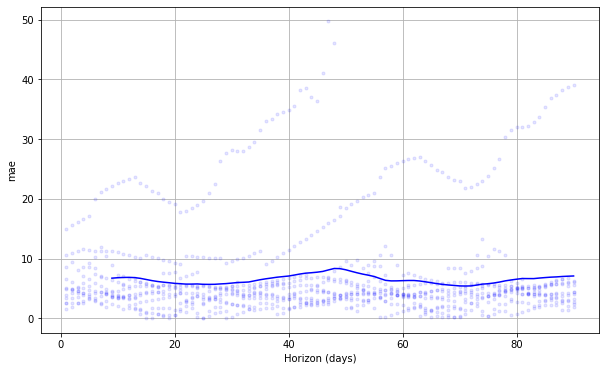

In [31]:
p = plot_cross_validation_metric(cv_results, 'mae')

/opt/homebrew/Caskroom/miniforge/base/envs/hackathon/lib/python3.9/site-packages/prophet/plot.py:539: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])
/opt/homebrew/Caskroom/miniforge/base/envs/hackathon/lib/python3.9/site-packages/prophet/plot.py:540: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])


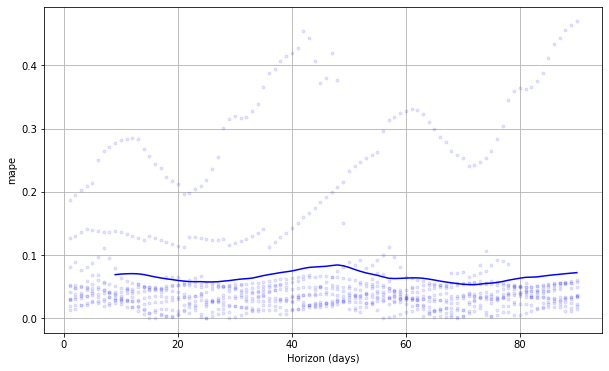

In [32]:
p = plot_cross_validation_metric(cv_results, 'mape')

#### Training

In [33]:
model3, model3_forecast, model3_fitted, _, _ = train_model(Prophet(), 
                                                           dummy_data, 
                                                           'FLOW_DATE', 
                                                           'RES_LEVEL_FT', 
                                                           external_regressors=list(dummy_data.drop(columns=['FLOW_DATE', 'RES_LEVEL_FT']).columns.values))

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -98.6196
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       8298.79    0.00399443       869.869           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        8454.3      0.015254          2391           1           1      226   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       8504.92    0.00908887       607.769           1           1      335   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399          8553     0.0229409       1022.65           1           1      439   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       8581.23    0.00124477       343.454           1           1      547   
    Iter      log prob        ||dx||      ||grad||       alpha  

#### Evaluation

##### Train Set

<AxesSubplot:xlabel='FLOW_DATE'>

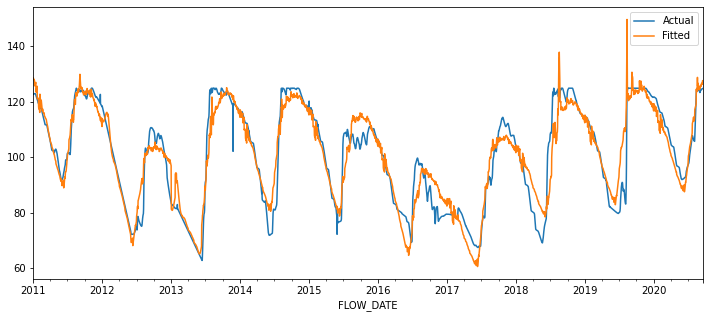

In [34]:
model3_fitted.plot(figsize=(12, 5))

In [35]:
model_evaluation(model3_fitted, mean_absolute_error, 'Fitted', 'Actual')

4.3

In [36]:
model_evaluation(model3_fitted, mean_absolute_percentage_error, 'Fitted', 'Actual')

0.05

##### Test Set

<AxesSubplot:xlabel='FLOW_DATE'>

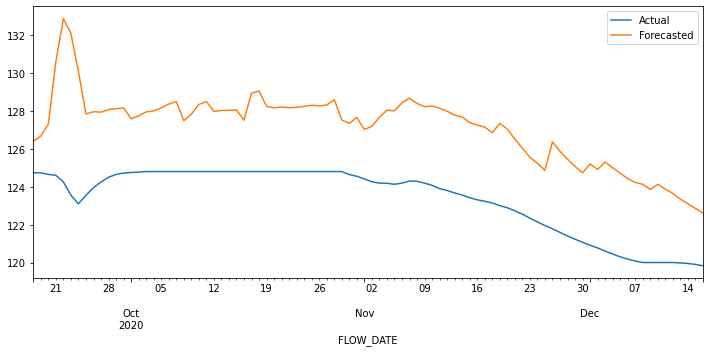

In [37]:
model3_forecast.plot(figsize=(12, 5))

In [38]:
model_evaluation(model3_forecast, mean_absolute_error, 'Forecasted', 'Actual')

3.77

In [39]:
model_evaluation(model3_forecast, mean_absolute_percentage_error, 'Forecasted', 'Actual')

0.03

### Model 4

Independent Variables:
* Diff(RES_LEVEL_FT)
* INFLOW_CUSECS - OUTFLOW_CUECS
* WEEK_NO
* MONTH_NO

In [40]:
from sklearn.preprocessing import OneHotEncoder

In [41]:
dummy_data = dataset.copy()
dummy_data['RES_LEVEL_FT'] = dummy_data['RES_LEVEL_FT'].diff()
dummy_data['FLOW_DIFF'] = dummy_data['INFLOW_CUSECS'] - dummy_data['OUTFLOW_CUECS']
dummy_data = dummy_data.drop(columns=['INFLOW_CUSECS', 'OUTFLOW_CUECS'])
dummy_data = dummy_data.dropna()
dummy_data['WEEK_NO'] = dummy_data['WEEK_NO'].astype(int).astype(str)
dummy_data['MONTH_NO'] = dummy_data['MONTH_NO'].astype(int).astype(str)

In [42]:
dummy_data = pd.get_dummies(dummy_data)

In [43]:
cv_results, cv_performance = cross_validate_model(Prophet(), 
                                                  dummy_data, 
                                                  'FLOW_DATE', 
                                                  'RES_LEVEL_FT', 
                                                  external_regressors=list(dummy_data.drop(columns=['FLOW_DATE', 'RES_LEVEL_FT']).columns.values))

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 11 forecasts with cutoffs between 2019-05-06 00:00:00 and 2020-09-17 00:00:00


Initial log joint probability = -5.6199
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99         10591   0.000140883       512.845      0.1128      0.1128      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       10592.8    0.00183505       137.998           1           1      228   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       10593.3   0.000396695       97.9338      0.7793      0.7793      341   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       10593.4   3.37492e-05        78.849       0.601       0.601      449   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     421       10593.4   2.31599e-05       80.6893   2.676e-07       0.001      529  LS failed, Hessian reset 
     499       10593.4   4.35829e-07     

  0%|          | 0/11 [00:00<?, ?it/s]

Initial log joint probability = -5.51369
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       8682.25   0.000478566       151.073           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       8683.07   0.000190742       203.231      0.5142      0.5142      230   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       8683.33   1.80047e-05       80.5135      0.6452      0.6452      353   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     349       8683.34   1.97633e-07       76.6816     0.07477           1      418   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -4.94979
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    

Initial log joint probability = -5.81539
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       9794.77   0.000940395       315.894           1           1      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       9796.13    0.00100843       193.317           1           1      226   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        9796.6   3.34116e-05       69.7852      0.3686           1      348   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       9796.69   0.000196774       97.9871      0.4212      0.9941      464   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     476       9796.71   5.32462e-06       70.0781      0.3185      0.3185      557   
Optimization terminated normally: 
  Convergence detected: relat

INFO:prophet:Skipping MAPE because y close to 0


In [44]:
b = dataset[dataset['FLOW_DATE'] >= '2016-01-22']

In [45]:
cv_results.loc[0, 'y'] = cv_results.loc[0, 'y'] + b.iloc[0, 1]
cv_results.loc[0, 'yhat'] = cv_results.loc[0, 'yhat'] + b.iloc[0, 1]

In [46]:
cv_results['yhat'] = cv_results['yhat'].cumsum()
cv_results['y'] = cv_results['y'].cumsum()

In [47]:
cv_results

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2019-05-07,100.412242,-0.975866,0.594737,100.080000,2019-05-06
1,2019-05-08,100.222281,-0.949971,0.583669,99.660000,2019-05-06
2,2019-05-09,99.992178,-0.972498,0.575591,99.090000,2019-05-06
3,2019-05-10,99.756300,-1.024221,0.566968,98.680000,2019-05-06
4,2019-05-11,99.665107,-0.874149,0.628859,98.620000,2019-05-06
...,...,...,...,...,...,...
985,2020-12-12,154.782899,-0.771041,0.749289,144.629333,2020-09-17
986,2020-12-13,154.688374,-0.778443,0.656186,144.609333,2020-09-17
987,2020-12-14,154.639635,-0.814771,0.685596,144.579333,2020-09-17
988,2020-12-15,154.547361,-0.756489,0.642223,144.529333,2020-09-17


/opt/homebrew/Caskroom/miniforge/base/envs/hackathon/lib/python3.9/site-packages/prophet/plot.py:539: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])
/opt/homebrew/Caskroom/miniforge/base/envs/hackathon/lib/python3.9/site-packages/prophet/plot.py:540: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])


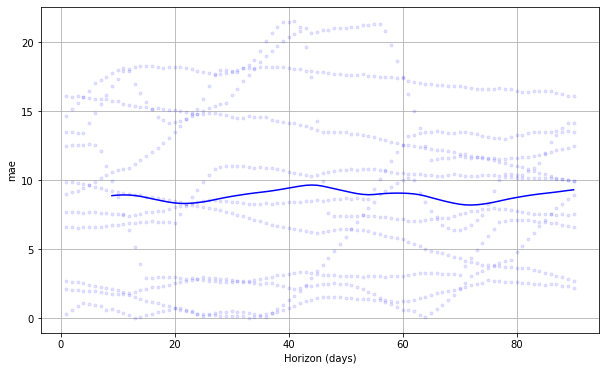

In [48]:
p = plot_cross_validation_metric(cv_results, 'mae')

/opt/homebrew/Caskroom/miniforge/base/envs/hackathon/lib/python3.9/site-packages/prophet/plot.py:539: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])
/opt/homebrew/Caskroom/miniforge/base/envs/hackathon/lib/python3.9/site-packages/prophet/plot.py:540: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])


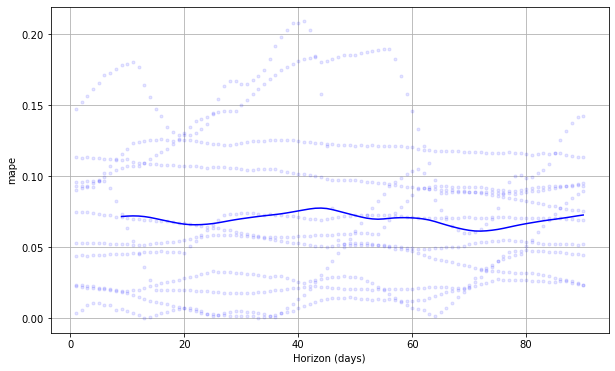

In [49]:
p = plot_cross_validation_metric(cv_results, 'mape')

#### Training

In [50]:
model4, model4_forecast, model4_fitted, _, _ = train_model(Prophet(), 
                                                           dummy_data, 
                                                           'FLOW_DATE', 
                                                           'RES_LEVEL_FT', 
                                                           external_regressors=list(dummy_data.drop(columns=['FLOW_DATE', 'RES_LEVEL_FT']).columns.values))

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -5.61722
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       10287.3   0.000455883       442.113      0.4442           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       10288.7   0.000830575       180.365      0.6986      0.6986      228   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       10289.5   0.000934794       181.829           1           1      335   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       10289.6   0.000141533       96.3108      0.4133      0.9419      452   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       10289.6   1.11161e-05       63.7824           1           1      571   
    Iter      log prob        ||dx||      ||grad||       alpha  

In [51]:
model4_fitted.iloc[0, 0] = model4_fitted.iloc[0, 0] + dataset['RES_LEVEL_FT'].values[0]
model4_fitted['Actual'] = model4_fitted['Actual'].cumsum()

model4_fitted.iloc[0, 1] = model4_fitted.iloc[0, 1] + dataset['RES_LEVEL_FT'].values[0]
model4_fitted['Fitted'] = model4_fitted['Fitted'].cumsum()

In [52]:
model4_fitted

,Actual,Fitted
FLOW_DATE,,
2011-01-02,122.68,122.610913
2011-01-03,122.75,122.650775
2011-01-04,122.79,122.624176
2011-01-05,122.80,122.543859
2011-01-06,122.83,122.484401
...,...,...
2020-09-13,124.57,124.606152
2020-09-14,124.63,124.658954
2020-09-15,124.67,124.683168


In [53]:
model4_forecast.iloc[0, 0] = model4_forecast.iloc[0, 0] + model4_fitted.iloc[-1, 0]
model4_forecast['Actual'] = model4_forecast['Actual'].cumsum()

model4_forecast.iloc[0, 1] = model4_forecast.iloc[0, 1] + model4_fitted.iloc[-1, 0]
model4_forecast['Forecasted'] = model4_forecast['Forecasted'].cumsum()

#### Evaluation

##### Train Set

<AxesSubplot:xlabel='FLOW_DATE'>

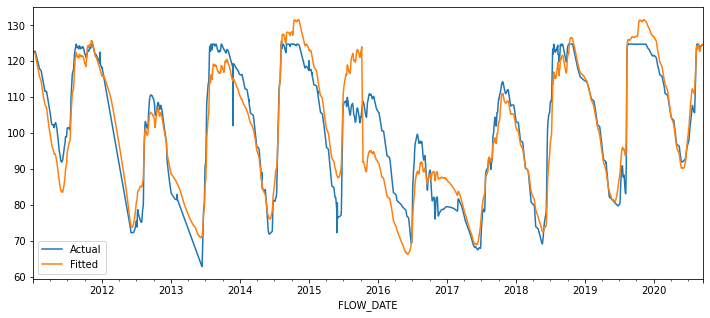

In [54]:
model4_fitted.plot(figsize=(12, 5))

In [55]:
model_evaluation(model4_fitted, mean_absolute_error, 'Fitted', 'Actual')

4.77

In [56]:
model_evaluation(model4_fitted, mean_absolute_percentage_error, 'Fitted', 'Actual')

0.05

##### Test Set

<AxesSubplot:xlabel='FLOW_DATE'>

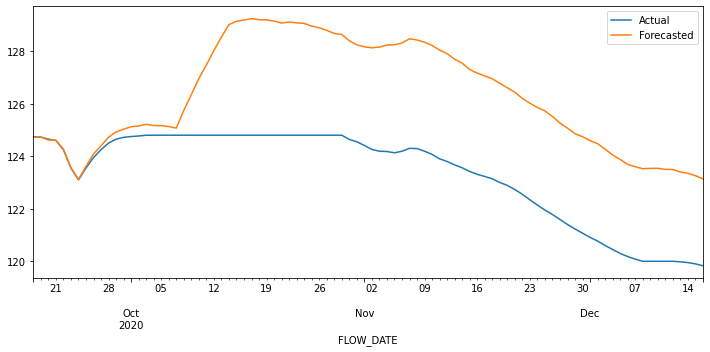

In [57]:
model4_forecast.plot(figsize=(12, 5))

In [58]:
model_evaluation(model4_forecast, mean_absolute_error, 'Forecasted', 'Actual')

2.95

In [59]:
model_evaluation(model4_forecast, mean_absolute_percentage_error, 'Forecasted', 'Actual')

0.02

### Model 5

Dependent:
* Diff(RES_LEVEL_FT)

Independent Variables:
* INFLOW_CUSECS - OUTFLOW_CUECS
* WEEK_NO
* MONTH_NO

#### Training

In [60]:
from sklearn.preprocessing import OneHotEncoder

In [61]:
inflow_dataset = dataset[['INFLOW_CUSECS', 'FLOW_DATE', 'WEEK_NO', 'MONTH_NO']].copy()
inflow_dataset['WEEK_NO'] = inflow_dataset['WEEK_NO'].astype(int).astype(str)
inflow_dataset['MONTH_NO'] = inflow_dataset['MONTH_NO'].astype(int).astype(str)

In [62]:
dummy_data = pd.get_dummies(inflow_dataset)

In [63]:
inflow_cv_results, inflow_cv_performance = cross_validate_model(Prophet(yearly_seasonality=10),
                                                                 dummy_data,
                                                                 'FLOW_DATE',
                                                                 'INFLOW_CUSECS',
                                                                 external_regressors=list(dummy_data.drop(columns=['FLOW_DATE', 'INFLOW_CUSECS']).columns.values))

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 11 forecasts with cutoffs between 2019-05-06 00:00:00 and 2020-09-17 00:00:00


Initial log joint probability = -6.86089
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       9750.06    0.00214853       200.172           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       9758.58    0.00335638       233.402       1.212      0.1212      239   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        9762.2     0.0013446       127.315           1           1      358   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     333       9762.66    6.7722e-05       187.769   5.932e-07       0.001      428  LS failed, Hessian reset 
     399       9762.91   0.000268707       100.781           1           1      500   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     458        9763.3   0.000708507    

  0%|          | 0/11 [00:00<?, ?it/s]

Initial log joint probability = -10.3256
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        7264.5     0.0021833       214.872      0.9835      0.9835      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199          7268    0.00494392       127.496           1           1      224   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       7269.69   0.000835156       82.0839           1           1      345   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     308       7269.76   0.000161152       142.331   1.933e-06       0.001      389  LS failed, Hessian reset 
     381       7269.94    4.5695e-05        90.749     5.5e-07       0.001      519  LS failed, Hessian reset 
     399       7269.95   3.74195e-06       67.6894      0.9474      0.9474      542   
    Iter      log pro

Initial log joint probability = -7.02973
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       8874.19   0.000588327       172.894           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       8879.28   0.000517772       167.379           1           1      236   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       8881.69    0.00228921       420.836           1           1      347   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     366       8882.28   8.86891e-05       194.626   1.007e-06       0.001      466  LS failed, Hessian reset 
     398       8882.31   1.35032e-05       77.8301   1.545e-07       0.001      540  LS failed, Hessian reset 
     399       8882.31     9.157e-06       69.3161           1           1      541   
    Iter      log pro

/opt/homebrew/Caskroom/miniforge/base/envs/hackathon/lib/python3.9/site-packages/prophet/plot.py:539: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])
/opt/homebrew/Caskroom/miniforge/base/envs/hackathon/lib/python3.9/site-packages/prophet/plot.py:540: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])


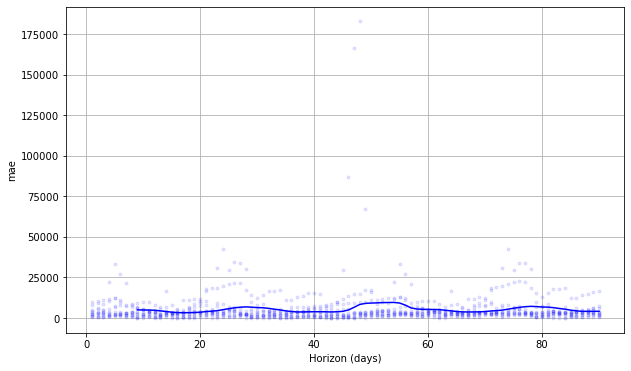

In [64]:
p = plot_cross_validation_metric(inflow_cv_results, 'mae')

/opt/homebrew/Caskroom/miniforge/base/envs/hackathon/lib/python3.9/site-packages/prophet/plot.py:539: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])
/opt/homebrew/Caskroom/miniforge/base/envs/hackathon/lib/python3.9/site-packages/prophet/plot.py:540: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])


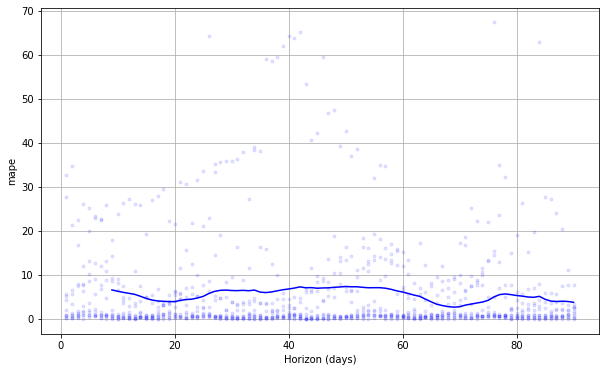

In [65]:
p = plot_cross_validation_metric(inflow_cv_results, 'mape')

In [66]:
inflow_model, inflow_forecast, inflow_fitted, _, _ = train_model(Prophet(yearly_seasonality=10),
                                                                 dummy_data,
                                                                 'FLOW_DATE',
                                                                 'INFLOW_CUSECS',
                                                                 external_regressors=list(dummy_data.drop(columns=['FLOW_DATE', 'INFLOW_CUSECS']).columns.values))

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -6.62779
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        9486.3    0.00394526       409.688           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        9492.1    0.00287543       221.444           1           1      238   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       9497.95    0.00286548        111.64           1           1      353   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       9499.49   0.000493783       92.0024           1           1      468   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       9500.86    0.00800594         472.9           1           1      588   
    Iter      log prob        ||dx||      ||grad||       alpha  

#### Evaluation

##### Train Set

<AxesSubplot:xlabel='FLOW_DATE'>

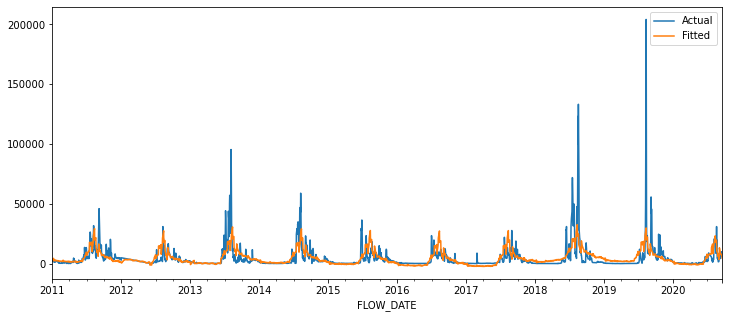

In [67]:
inflow_fitted.plot(figsize=(12, 5))

In [68]:
model_evaluation(inflow_fitted[inflow_fitted['Actual'] != 0], mean_absolute_error, 'Fitted', 'Actual')

3561.24

In [69]:
model_evaluation(inflow_fitted[inflow_fitted['Actual'] != 0], mean_absolute_percentage_error, 'Fitted', 'Actual')

3.34

##### Test Set

<AxesSubplot:xlabel='FLOW_DATE'>

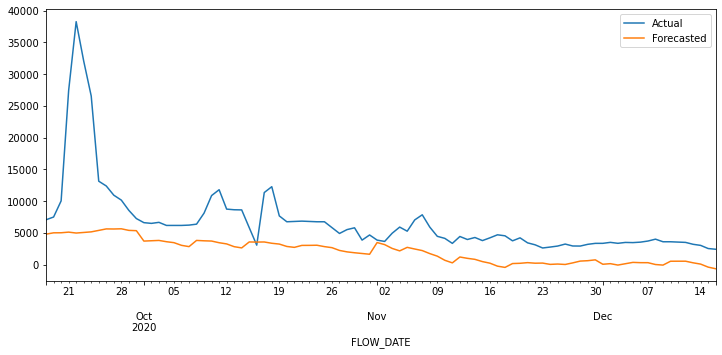

In [70]:
inflow_forecast.plot(figsize=(12, 5))

In [71]:
model_evaluation(inflow_forecast[inflow_forecast['Actual'] != 0], mean_absolute_error, 'Forecasted', 'Actual')

4622.06

In [72]:
model_evaluation(inflow_forecast[inflow_forecast['Actual'] != 0], mean_absolute_percentage_error, 'Forecasted', 'Actual')

0.7

#### Outflow

In [73]:
outflow_dataset = dataset[['OUTFLOW_CUECS', 'FLOW_DATE', 'WEEK_NO', 'MONTH_NO']].copy()
outflow_dataset['WEEK_NO'] = outflow_dataset['WEEK_NO'].astype(int).astype(str)
outflow_dataset['MONTH_NO'] = outflow_dataset['MONTH_NO'].astype(int).astype(str)

In [74]:
dummy_data = pd.get_dummies(outflow_dataset)

In [75]:
outflow_cv_results, outflow_cv_performance = cross_validate_model(Prophet(yearly_seasonality=10),
                                                                 dummy_data,
                                                                 'FLOW_DATE',
                                                                 'OUTFLOW_CUECS',
                                                                 external_regressors=list(dummy_data.drop(columns=['FLOW_DATE', 'OUTFLOW_CUECS']).columns.values))

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 11 forecasts with cutoffs between 2019-05-06 00:00:00 and 2020-09-17 00:00:00


Initial log joint probability = -8.89142
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       8849.94     0.0101443       257.236           1           1      112   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       8857.68   0.000468045       77.6116           1           1      233   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       8858.99    2.0242e-05       83.3065      0.3871           1      359   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     335       8859.05   0.000114549        73.775   1.414e-06       0.001      435  LS failed, Hessian reset 
     375       8859.08   4.26754e-07       69.3807     0.03686           1      487   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


  0%|          | 0/11 [00:00<?, ?it/s]

Initial log joint probability = -10.5167
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6834.71     0.0110424       244.146           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       6836.16   0.000123404       66.4028      0.6457      0.6457      245   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     211       6836.17   1.99554e-05        56.031    3.72e-07       0.001      299  LS failed, Hessian reset 
     278       6836.35   0.000139366       162.763   1.421e-06       0.001      435  LS failed, Hessian reset 
     299       6836.47   5.58468e-05       64.3889           1           1      458   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     388       6836.51   9.10489e-05       82.9325   1.707e-06       0.001      642  LS failed, Hessian rese

Initial log joint probability = -8.60239
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       8213.88    0.00109451       257.274      0.3008      0.3008      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       8219.77    0.00176646       126.333           1           1      240   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       8221.39   0.000627488       142.271           1           1      354   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       8221.95   0.000136316       82.6812      0.9496      0.9496      470   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       8222.09    8.3668e-05       74.1142           1           1      584   
    Iter      log prob        ||dx||      ||grad||       alpha  

/opt/homebrew/Caskroom/miniforge/base/envs/hackathon/lib/python3.9/site-packages/prophet/plot.py:539: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])
/opt/homebrew/Caskroom/miniforge/base/envs/hackathon/lib/python3.9/site-packages/prophet/plot.py:540: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])


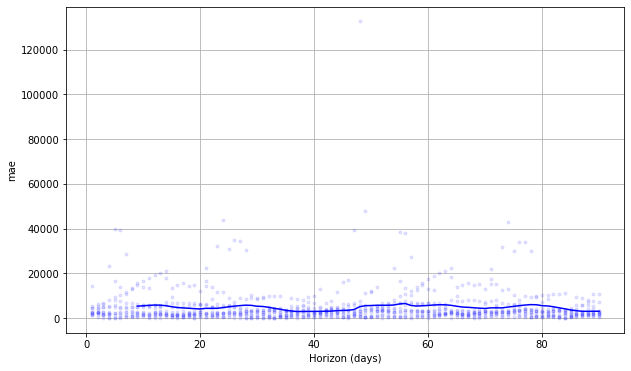

In [76]:
p = plot_cross_validation_metric(outflow_cv_results, 'mae')

/opt/homebrew/Caskroom/miniforge/base/envs/hackathon/lib/python3.9/site-packages/prophet/plot.py:539: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])
/opt/homebrew/Caskroom/miniforge/base/envs/hackathon/lib/python3.9/site-packages/prophet/plot.py:540: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])


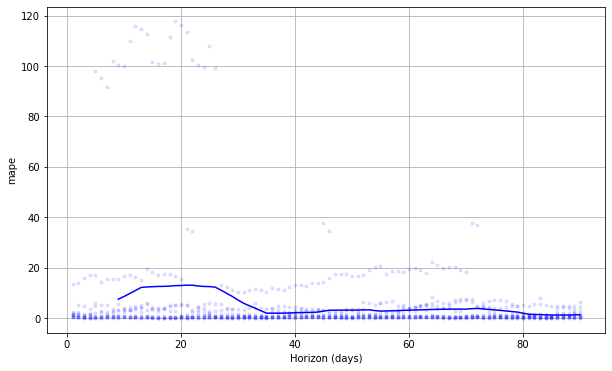

In [77]:
p = plot_cross_validation_metric(outflow_cv_results, 'mape')

In [78]:
outflow_model, outflow_forecast, outflow_fitted, _, _ = train_model(Prophet(yearly_seasonality=10),
                                                                 dummy_data,
                                                                 'FLOW_DATE',
                                                                 'OUTFLOW_CUECS',
                                                                 external_regressors=list(dummy_data.drop(columns=['FLOW_DATE', 'OUTFLOW_CUECS']).columns.values))

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -8.59194
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       8621.44   0.000662602       414.232      0.4456      0.4456      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       8625.24    0.00039126       85.2003      0.3857      0.3857      229   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     249       8625.71   0.000492571       106.136   5.725e-06       0.001      329  LS failed, Hessian reset 
     299       8625.82   2.88771e-05        72.919      0.8927      0.8927      386   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       8626.64    0.00138563        73.815        0.33           1      495   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       8627.27   7.92978e-05    

#### Evaluation

##### Train Set

<AxesSubplot:xlabel='FLOW_DATE'>

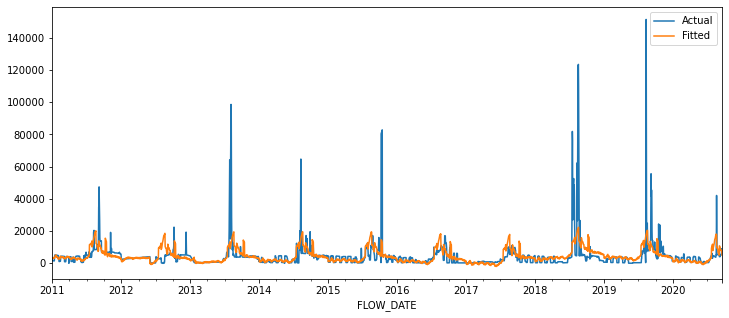

In [79]:
outflow_fitted.plot(figsize=(12, 5))

In [80]:
model_evaluation(outflow_fitted[outflow_fitted['Actual'] != 0], mean_absolute_error, 'Fitted', 'Actual')

3112.8

In [81]:
model_evaluation(outflow_fitted[outflow_fitted['Actual'] != 0], mean_absolute_percentage_error, 'Fitted', 'Actual')

2.15

##### Test Set

<AxesSubplot:xlabel='FLOW_DATE'>

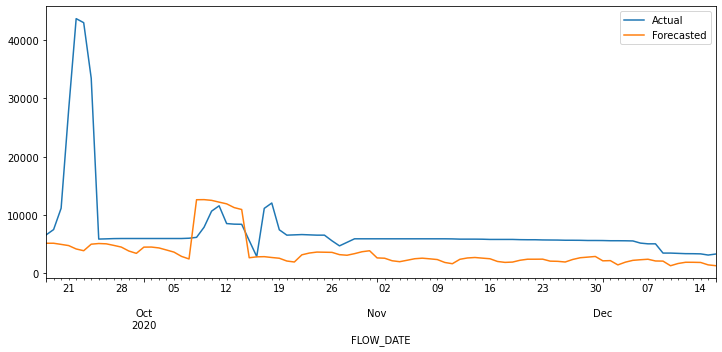

In [82]:
outflow_forecast.plot(figsize=(12, 5))

In [83]:
model_evaluation(outflow_forecast[outflow_forecast['Actual'] != 0], mean_absolute_error, 'Forecasted', 'Actual')

4355.32

In [84]:
model_evaluation(outflow_forecast[outflow_forecast['Actual'] != 0], mean_absolute_percentage_error, 'Forecasted', 'Actual')

0.52

#### Reservoir Level

In [85]:
dummy_data = dataset.copy()
dummy_data['RES_LEVEL_FT'] = dummy_data['RES_LEVEL_FT'].diff()

In [86]:
dummy_data.iloc[-90:, 2] = inflow_forecast['Forecasted']
dummy_data.iloc[-90:, 3] = outflow_forecast['Forecasted']

In [87]:
dummy_data['FLOW_DIFF'] = dummy_data['INFLOW_CUSECS'] - dummy_data['OUTFLOW_CUECS']
dummy_data = dummy_data.drop(columns=['INFLOW_CUSECS', 'OUTFLOW_CUECS'])
dummy_data = dummy_data.dropna()
dummy_data['WEEK_NO'] = dummy_data['WEEK_NO'].astype(int).astype(str)
dummy_data['MONTH_NO'] = dummy_data['MONTH_NO'].astype(int).astype(str)

In [88]:
dummy_data = pd.get_dummies(dummy_data)

In [89]:
cv_results, cv_performance = cross_validate_model(Prophet(), 
                                                  dummy_data, 
                                                  'FLOW_DATE', 
                                                  'RES_LEVEL_FT', 
                                                  external_regressors=list(dummy_data.drop(columns=['FLOW_DATE', 'RES_LEVEL_FT']).columns.values))

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 11 forecasts with cutoffs between 2019-05-06 00:00:00 and 2020-09-17 00:00:00


Initial log joint probability = -5.6199
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       10590.9    0.00168865       234.198           1           1      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       10592.9   0.000280488       193.234           1           1      222   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       10593.4   0.000768545       229.881      0.8842      0.8842      335   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     357       10593.4   2.02376e-05       87.6129   2.435e-07       0.001      443  LS failed, Hessian reset 
     399       10593.4   3.12257e-06       86.9291      0.5352      0.5352      492   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     445       10593.5   1.18258e-05     

  0%|          | 0/11 [00:00<?, ?it/s]

Initial log joint probability = -5.51369
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       8682.25   0.000127855       69.6049           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       8683.03   0.000783913       119.088      0.9743      0.9743      232   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       8683.44   4.31214e-05       86.9636   4.204e-07       0.001      382  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     333       8683.44   4.87858e-07       76.1055           1           1      426   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -4.94979
    Iter      log prob        ||dx||      ||grad||       alpha      alph

Initial log joint probability = -5.57591
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       9963.55   0.000352959       147.045           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       9965.09   0.000360358       131.219           1           1      228   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       9965.34   7.40578e-05       111.806      0.4815           1      346   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       9965.42     2.542e-05       114.759      0.9267      0.9267      465   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       9965.45   7.42565e-06       68.6457       0.846       0.846      586   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:prophet:Skipping MAPE because y close to 0


In [90]:
b = dataset[dataset['FLOW_DATE'] >= '2019-05-06']

In [91]:
cv_results.loc[0, 'y'] = cv_results.loc[0, 'y'] + b.iloc[0, 1]
cv_results.loc[0, 'yhat'] = cv_results.loc[0, 'yhat'] + b.iloc[0, 1]

In [92]:
cv_results['yhat'] = cv_results['yhat'].cumsum()
cv_results['y'] = cv_results['y'].cumsum()

<AxesSubplot:>

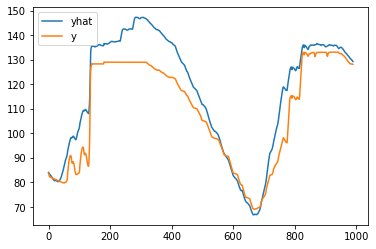

In [93]:
cv_results[['yhat', 'y']].plot()

/opt/homebrew/Caskroom/miniforge/base/envs/hackathon/lib/python3.9/site-packages/prophet/plot.py:539: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])
/opt/homebrew/Caskroom/miniforge/base/envs/hackathon/lib/python3.9/site-packages/prophet/plot.py:540: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])


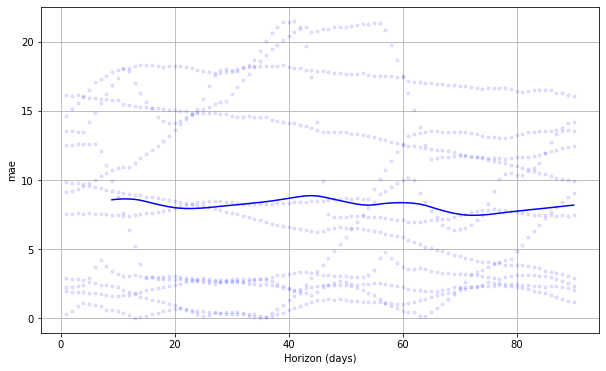

In [94]:
p = plot_cross_validation_metric(cv_results, 'mae')

/opt/homebrew/Caskroom/miniforge/base/envs/hackathon/lib/python3.9/site-packages/prophet/plot.py:539: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])
/opt/homebrew/Caskroom/miniforge/base/envs/hackathon/lib/python3.9/site-packages/prophet/plot.py:540: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])


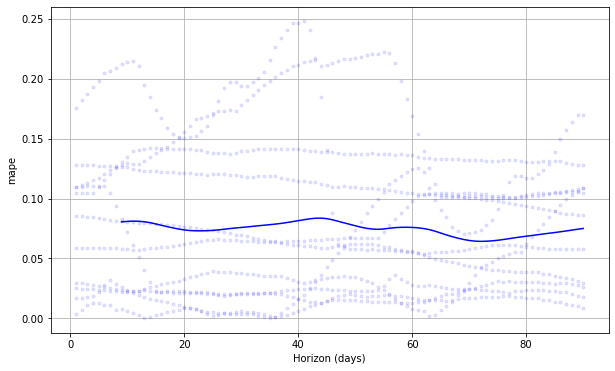

In [95]:
p = plot_cross_validation_metric(cv_results, 'mape')

In [96]:
model5, model5_forecast, model5_fitted, _, _ = train_model(Prophet(), 
                                                           dummy_data, 
                                                           'FLOW_DATE', 
                                                           'RES_LEVEL_FT', 
                                                           external_regressors=list(dummy_data.drop(columns=['FLOW_DATE', 'RES_LEVEL_FT']).columns.values))

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -5.61722
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       10287.3   0.000455883       442.113      0.4442           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       10288.7   0.000830575       180.365      0.6986      0.6986      228   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       10289.5   0.000934794       181.829           1           1      335   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       10289.6   0.000141533       96.3108      0.4133      0.9419      452   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       10289.6   1.11161e-05       63.7824           1           1      571   
    Iter      log prob        ||dx||      ||grad||       alpha  

In [97]:
model5_fitted.iloc[0, 0] = model5_fitted.iloc[0, 0] + dataset['RES_LEVEL_FT'].values[0]
model5_fitted['Actual'] = model5_fitted['Actual'].cumsum()

model5_fitted.iloc[0, 1] = model5_fitted.iloc[0, 1] + dataset['RES_LEVEL_FT'].values[0]
model5_fitted['Fitted'] = model5_fitted['Fitted'].cumsum()

In [98]:
model5_forecast.iloc[0, 0] = model5_forecast.iloc[0, 0] + model4_fitted.iloc[-1, 0]
model5_forecast['Actual'] = model5_forecast['Actual'].cumsum()

model5_forecast.iloc[0, 1] = model5_forecast.iloc[0, 1] + model4_fitted.iloc[-1, 0]
model5_forecast['Forecasted'] = model5_forecast['Forecasted'].cumsum()

#### Evaluation

##### Train Set

<AxesSubplot:xlabel='FLOW_DATE'>

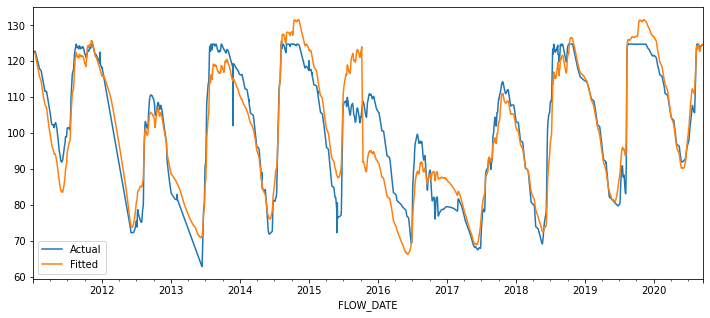

In [99]:
model5_fitted.plot(figsize=(12, 5))

In [100]:
model_evaluation(model5_fitted, mean_absolute_error, 'Fitted', 'Actual')

4.77

In [101]:
model_evaluation(model5_fitted, mean_absolute_percentage_error, 'Fitted', 'Actual')

0.05

##### Test Set

<AxesSubplot:xlabel='FLOW_DATE'>

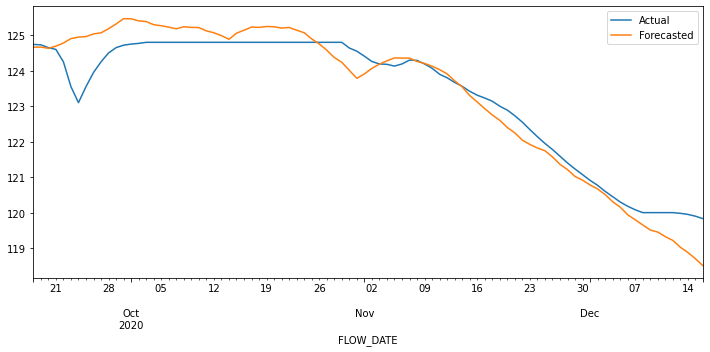

In [102]:
model5_forecast.plot(figsize=(12, 5))

In [103]:
model_evaluation(model5_forecast, mean_absolute_error, 'Forecasted', 'Actual')

0.41

In [104]:
model_evaluation(model5_forecast, mean_absolute_percentage_error, 'Forecasted', 'Actual')

0.0

### Model 6

Independent Variables:
* Diff(RES_LEVEL_FT)
* INFLOW_CUSECS - OUTFLOW_CUECS
* WEEK_NO
* MONTH_NO

Multiplicative Seasonality

#### Training

In [105]:
from sklearn.preprocessing import OneHotEncoder

In [106]:
inflow_dataset = dataset[['INFLOW_CUSECS', 'FLOW_DATE', 'WEEK_NO', 'MONTH_NO']].copy()
inflow_dataset['WEEK_NO'] = inflow_dataset['WEEK_NO'].astype(int).astype(str)
inflow_dataset['MONTH_NO'] = inflow_dataset['MONTH_NO'].astype(int).astype(str)

In [107]:
dummy_data = pd.get_dummies(inflow_dataset)

In [108]:
inflow_cv_results, inflow_cv_performance = cross_validate_model(Prophet(yearly_seasonality=10, 
                                                                        seasonality_mode='multiplicative'),
                                                                dummy_data,
                                                                 'FLOW_DATE',
                                                                 'INFLOW_CUSECS',
                                                                 external_regressors=list(dummy_data.drop(columns=['FLOW_DATE', 'INFLOW_CUSECS']).columns.values))

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 11 forecasts with cutoffs between 2019-05-06 00:00:00 and 2020-09-17 00:00:00


Initial log joint probability = -6.86089
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       9907.58    0.00390505       985.865       0.937       0.937      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       9938.71      0.033356       2183.34           1           1      240   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       9982.11     0.0307122       1610.59           1           1      359   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399         10015     0.0235967       1779.19           1           1      497   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       10032.6    0.00533815       345.159     0.09752           1      633   
    Iter      log prob        ||dx||      ||grad||       alpha  

  0%|          | 0/11 [00:00<?, ?it/s]

Initial log joint probability = -10.3256
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       7565.93     0.0134627       1699.74           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       7654.15    0.00586974       1075.08      0.1053           1      254   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       7689.53    0.00480312       259.987      0.1249           1      374   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     348       7697.06   3.68586e-05        103.06   8.981e-08       0.001      488  LS failed, Hessian reset 
     399       7703.11    0.00195141        133.29           1           1      549   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       7711.81    0.00157303    

Initial log joint probability = -6.50888
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       8505.29      0.010819       631.533           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       8558.32    0.00350753       660.058           1           1      245   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       8596.99    0.00540555       580.502       2.226      0.2226      369   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       8618.58    0.00548346       508.094      0.7336      0.7336      502   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     422       8634.56    6.0541e-05       478.558   3.136e-07       0.001      575  LS failed, Hessian reset 
     499       8645.52    0.00712219    

Initial log joint probability = -6.96493
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       8858.51     0.0193284        942.89      0.6979      0.6979      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       8890.57    0.00487584       750.709           1           1      238   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       8911.03    0.00468807       204.768           1           1      366   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399          8948     0.0171992        280.26           1           1      488   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     471       8965.26   2.01398e-05       190.674   6.988e-08       0.001      618  LS failed, Hessian reset 
     499       8967.23   0.000115793    

Initial log joint probability = -7.03093
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       9179.59     0.0150822       759.321      0.4376           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       9221.28     0.0277872       722.968      0.3366           1      227   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       9272.67     0.0125319       816.221       1.329      0.1329      357   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       9300.19   0.000633722       332.203           1           1      488   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       9306.89   0.000332781       305.284      0.5218      0.5218      603   
    Iter      log prob        ||dx||      ||grad||       alpha  

Initial log joint probability = -6.75316
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       9504.97     0.0102938       632.315           1           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       9539.34    0.00427261        3174.5     0.05525           1      251   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       9591.65     0.0486545       3901.49      0.9147      0.9147      378   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       9610.75    0.00335403       761.756      0.3861      0.3861      503   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       9621.23    0.00991657       252.917           1           1      625   
    Iter      log prob        ||dx||      ||grad||       alpha  

/opt/homebrew/Caskroom/miniforge/base/envs/hackathon/lib/python3.9/site-packages/prophet/plot.py:539: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])
/opt/homebrew/Caskroom/miniforge/base/envs/hackathon/lib/python3.9/site-packages/prophet/plot.py:540: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])


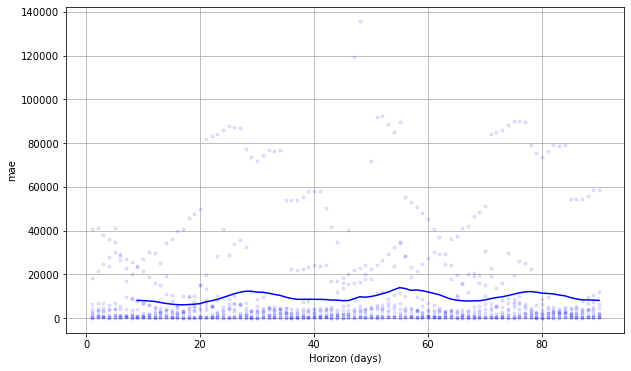

In [109]:
p = plot_cross_validation_metric(inflow_cv_results, 'mae')

/opt/homebrew/Caskroom/miniforge/base/envs/hackathon/lib/python3.9/site-packages/prophet/plot.py:539: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])
/opt/homebrew/Caskroom/miniforge/base/envs/hackathon/lib/python3.9/site-packages/prophet/plot.py:540: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])


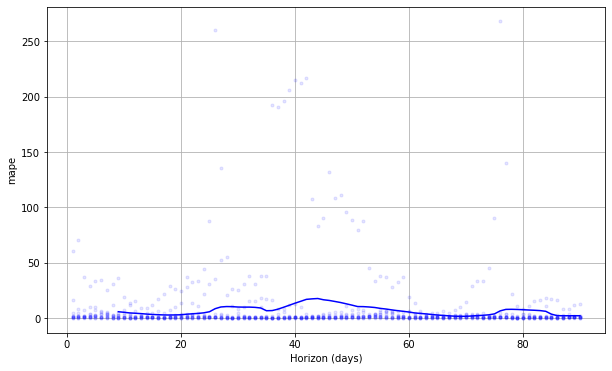

In [110]:
p = plot_cross_validation_metric(inflow_cv_results, 'mape')

In [111]:
inflow_model, inflow_forecast, inflow_fitted, _, _ = train_model(Prophet(yearly_seasonality=10, 
                                                                         seasonality_mode='multiplicative'),
                                                                 dummy_data,
                                                                 'FLOW_DATE',
                                                                 'INFLOW_CUSECS',
                                                                 external_regressors=list(dummy_data.drop(columns=['FLOW_DATE', 'INFLOW_CUSECS']).columns.values))

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -6.62779
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       9640.47     0.0211783       1142.54           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       9673.18    0.00368974       1796.42      0.2758           1      244   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       9704.18     0.0655316       1523.67           1           1      357   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       9745.43     0.0423269       460.344           1           1      478   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       9766.46     0.0143366       922.595        0.37           1      605   
    Iter      log prob        ||dx||      ||grad||       alpha  

#### Evaluation

##### Train Set

<AxesSubplot:xlabel='FLOW_DATE'>

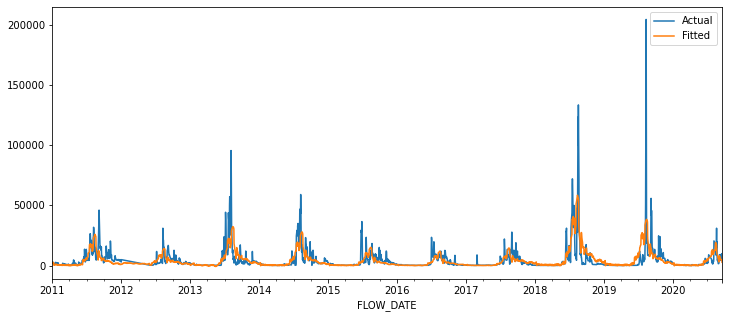

In [112]:
inflow_fitted.plot(figsize=(12, 5))

In [113]:
model_evaluation(inflow_fitted[inflow_fitted['Actual'] != 0], mean_absolute_error, 'Fitted', 'Actual')

3097.71

In [114]:
model_evaluation(inflow_fitted[inflow_fitted['Actual'] != 0], mean_absolute_percentage_error, 'Fitted', 'Actual')

1.61

##### Test Set

<AxesSubplot:xlabel='FLOW_DATE'>

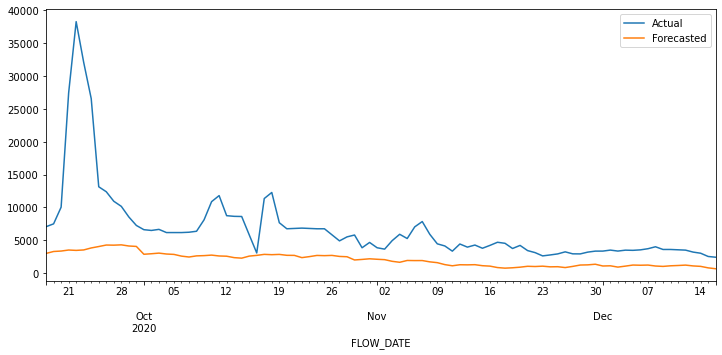

In [115]:
inflow_forecast.plot(figsize=(12, 5))

In [116]:
model_evaluation(inflow_forecast[inflow_forecast['Actual'] != 0], mean_absolute_error, 'Forecasted', 'Actual')

4700.7

In [117]:
model_evaluation(inflow_forecast[inflow_forecast['Actual'] != 0], mean_absolute_percentage_error, 'Forecasted', 'Actual')

0.65

#### Outflow

In [118]:
outflow_dataset = dataset[['OUTFLOW_CUECS', 'FLOW_DATE', 'WEEK_NO', 'MONTH_NO']].copy()
outflow_dataset['WEEK_NO'] = outflow_dataset['WEEK_NO'].astype(int).astype(str)
outflow_dataset['MONTH_NO'] = outflow_dataset['MONTH_NO'].astype(int).astype(str)

In [119]:
dummy_data = pd.get_dummies(outflow_dataset)

In [120]:
outflow_cv_results, outflow_cv_performance = cross_validate_model(Prophet(yearly_seasonality=10,
                                                                          seasonality_mode='multiplicative'),
                                                                 dummy_data,
                                                                 'FLOW_DATE',
                                                                 'OUTFLOW_CUECS',
                                                                 external_regressors=list(dummy_data.drop(columns=['FLOW_DATE', 'OUTFLOW_CUECS']).columns.values))

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 11 forecasts with cutoffs between 2019-05-06 00:00:00 and 2020-09-17 00:00:00


Initial log joint probability = -8.89142
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       8930.84    0.00327513       227.714           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       8954.74    0.00525226       337.885           1           1      244   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       9048.73     0.0013375       297.649           1           1      370   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       9072.28    0.00473922        410.37      0.3531      0.3531      499   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       9094.07    0.00143037       1449.22      0.2311           1      619   
    Iter      log prob        ||dx||      ||grad||       alpha  

  0%|          | 0/11 [00:00<?, ?it/s]

Initial log joint probability = -10.5167
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6957.05    0.00148006       377.309      0.5132      0.5132      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       7040.93     0.0682388       872.382          10           1      232   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       7107.77     0.0112296       288.529           1           1      348   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       7120.98   0.000317425       243.066      0.6074      0.6074      475   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       7125.26    0.00668229       157.125           1           1      592   
    Iter      log prob        ||dx||      ||grad||       alpha  

Initial log joint probability = -11.2254
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        7105.6    0.00713284       569.201           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       7193.75      0.062628       740.102      0.4644           1      238   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       7244.91     0.0314163       261.068           1           1      360   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       7263.64    0.00301628       1162.26      0.3215           1      478   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        7283.6     0.0065351       172.113      0.9595      0.9595      594   
    Iter      log prob        ||dx||      ||grad||       alpha  

Initial log joint probability = -24.3504
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       7595.45      0.003694       386.012           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       7662.83   0.000928249       263.829           1           1      241   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       7715.41    0.00848563       365.885           1           1      369   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       7743.02    0.00134907       414.759           1           1      494   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       7758.73   0.000272388       315.062      0.2315      0.2315      627   
    Iter      log prob        ||dx||      ||grad||       alpha  

Initial log joint probability = -8.46817
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       7663.76    0.00366108       951.016      0.4143           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       7727.41     0.0102219       424.202           1           1      230   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       7790.09    0.00710586       512.366           1           1      350   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       7808.15     0.0117142       1263.07      0.3461           1      471   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       7829.94    0.00399802       135.499           1           1      592   
    Iter      log prob        ||dx||      ||grad||       alpha  

Initial log joint probability = -8.50655
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       7804.41     0.0722312       807.685           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       7854.75    0.00542803       878.616           1           1      248   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       7896.31     0.0366158       2403.18           1           1      363   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       7933.17    0.00544365       249.297      0.9452      0.9452      477   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       7952.45    0.00767734       798.773     0.03924           1      599   
    Iter      log prob        ||dx||      ||grad||       alpha  

Initial log joint probability = -9.09176
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       7998.66     0.0538373       560.537           1           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       8052.12     0.0197195       717.037           1           1      243   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       8111.87      0.162797       4715.72      0.7141      0.7141      363   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       8135.22     0.0095849       221.911           1           1      485   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     492       8139.17   3.00959e-05       136.516    1.97e-07       0.001      649  LS failed, Hessian reset 
     499       8139.76   0.000385429    

Initial log joint probability = -8.68621
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       8111.16     0.0156794       3166.47           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       8203.15     0.0350431       272.423           1           1      244   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       8252.31      0.013028       447.758      0.7259      0.7259      369   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     395       8281.76   2.37738e-05       126.023   1.473e-07       0.001      523  LS failed, Hessian reset 
     399       8282.08    0.00270859       195.411           1           1      528   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       8289.13     0.0146013    

Initial log joint probability = -9.19261
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       8453.09    0.00139599       373.206           1           1      112   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       8529.87     0.0276704       973.378           1           1      229   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       8579.91     0.0013628       469.707      0.4901      0.4901      353   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       8611.87     0.0369976       680.513           1           1      477   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        8621.1    0.00748342       185.381       2.533      0.2533      606   
    Iter      log prob        ||dx||      ||grad||       alpha  

Initial log joint probability = -8.67217
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       8605.91     0.0189769       355.395           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       8669.58    0.00315018       4947.24      0.1534           1      235   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       8726.67    0.00884351       819.289      0.5688      0.5688      353   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        8740.8    0.00143857       318.687      0.2612           1      483   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       8747.78    0.00334488       271.871           1           1      607   
    Iter      log prob        ||dx||      ||grad||       alpha  

Initial log joint probability = -8.59194
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       8721.87    0.00704406       309.107           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       8781.01     0.0119711       3681.39      0.6474      0.6474      250   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       8853.77     0.0157632       456.764     0.05267           1      372   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       8872.62     0.0302726       708.842       1.591      0.1591      492   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       8892.36    0.00725114       454.468           1           1      628   
    Iter      log prob        ||dx||      ||grad||       alpha  

/opt/homebrew/Caskroom/miniforge/base/envs/hackathon/lib/python3.9/site-packages/prophet/plot.py:539: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])
/opt/homebrew/Caskroom/miniforge/base/envs/hackathon/lib/python3.9/site-packages/prophet/plot.py:540: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])


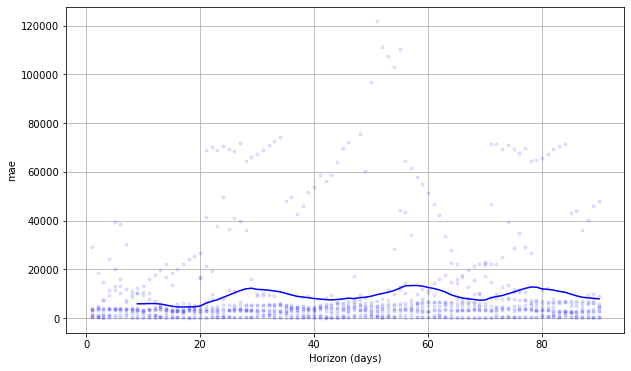

In [121]:
p = plot_cross_validation_metric(outflow_cv_results, 'mae')

/opt/homebrew/Caskroom/miniforge/base/envs/hackathon/lib/python3.9/site-packages/prophet/plot.py:539: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])
/opt/homebrew/Caskroom/miniforge/base/envs/hackathon/lib/python3.9/site-packages/prophet/plot.py:540: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])


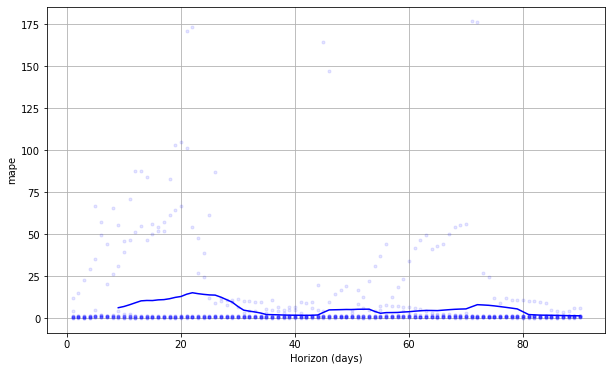

In [122]:
p = plot_cross_validation_metric(outflow_cv_results, 'mape')

In [123]:
outflow_model, outflow_forecast, outflow_fitted, _, _ = train_model(Prophet(yearly_seasonality=10,
                                                                            seasonality_mode='multiplicative'),
                                                                 dummy_data,
                                                                 'FLOW_DATE',
                                                                 'OUTFLOW_CUECS',
                                                                 external_regressors=list(dummy_data.drop(columns=['FLOW_DATE', 'OUTFLOW_CUECS']).columns.values))

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -8.59194
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       8721.87    0.00704406       309.107           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       8781.01     0.0119711       3681.39      0.6474      0.6474      250   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       8853.77     0.0157632       456.764     0.05267           1      372   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       8872.62     0.0302726       708.842       1.591      0.1591      492   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       8892.36    0.00725114       454.468           1           1      628   
    Iter      log prob        ||dx||      ||grad||       alpha  

#### Evaluation

##### Train Set

<AxesSubplot:xlabel='FLOW_DATE'>

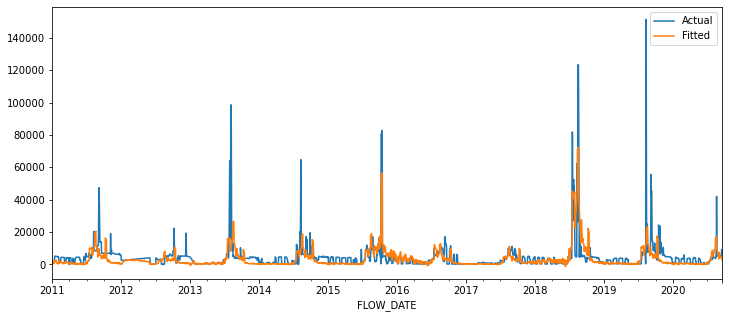

In [124]:
outflow_fitted.plot(figsize=(12, 5))

In [125]:
model_evaluation(outflow_fitted[outflow_fitted['Actual'] != 0], mean_absolute_error, 'Fitted', 'Actual')

3165.77

In [126]:
model_evaluation(outflow_fitted[outflow_fitted['Actual'] != 0], mean_absolute_percentage_error, 'Fitted', 'Actual')

1.21

##### Test Set

<AxesSubplot:xlabel='FLOW_DATE'>

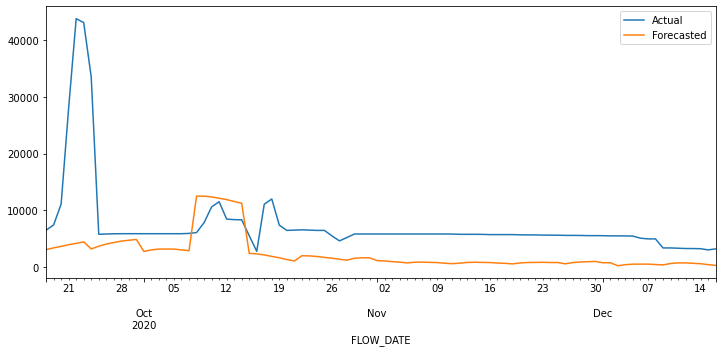

In [127]:
outflow_forecast.plot(figsize=(12, 5))

In [128]:
model_evaluation(outflow_forecast[outflow_forecast['Actual'] != 0], mean_absolute_error, 'Forecasted', 'Actual')

5410.83

In [129]:
model_evaluation(outflow_forecast[outflow_forecast['Actual'] != 0], mean_absolute_percentage_error, 'Forecasted', 'Actual')

0.71

#### Reservoir Level

In [130]:
dummy_data = dataset.copy()
dummy_data['RES_LEVEL_FT'] = dummy_data['RES_LEVEL_FT'].diff()

In [131]:
dummy_data.iloc[-90:, 2] = inflow_forecast['Forecasted'].clip(0)
dummy_data.iloc[-90:, 3] = outflow_forecast['Forecasted'].clip(0)

In [132]:
dummy_data['FLOW_DIFF'] = dummy_data['INFLOW_CUSECS'] - dummy_data['OUTFLOW_CUECS']
dummy_data = dummy_data.drop(columns=['INFLOW_CUSECS', 'OUTFLOW_CUECS'])
dummy_data = dummy_data.dropna()
dummy_data['WEEK_NO'] = dummy_data['WEEK_NO'].astype(int).astype(str)
dummy_data['MONTH_NO'] = dummy_data['MONTH_NO'].astype(int).astype(str)

In [133]:
dummy_data = pd.get_dummies(dummy_data)

In [134]:
cv_results, cv_performance = cross_validate_model(Prophet(yearly_seasonality=10), 
                                                  dummy_data, 
                                                  'FLOW_DATE', 
                                                  'RES_LEVEL_FT', 
                                                  external_regressors=list(dummy_data.drop(columns=['FLOW_DATE', 'RES_LEVEL_FT']).columns.values))

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 11 forecasts with cutoffs between 2019-05-06 00:00:00 and 2020-09-17 00:00:00


Initial log joint probability = -5.6199
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       10590.8    0.00120376        260.93           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       10592.4   0.000379873       112.859      0.5678      0.5678      231   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       10592.9   0.000184184       235.247           1           1      350   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       10593.2   0.000225349       64.6033           1           1      463   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     473       10593.3   1.19549e-05       102.012   1.509e-07       0.001      597  LS failed, Hessian reset 
     499       10593.3    2.9504e-06     

  0%|          | 0/11 [00:00<?, ?it/s]

Initial log joint probability = -5.51369
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       8682.25   0.000471635       109.227           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       8683.03   0.000192109       157.502           1           1      227   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       8683.35   9.83858e-06       79.2679      0.1467     0.01467      354   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     330       8683.36   7.87917e-07       70.9902      0.2619      0.7697      389   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -4.94979
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    

Initial log joint probability = -5.81539
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       9794.76   9.11737e-05       233.845      0.3341      0.3341      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       9796.14   4.45458e-05       137.463       0.619       0.619      223   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       9796.66   5.43773e-05       89.7671      0.4107      0.4107      336   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     331       9796.66   5.62276e-07       90.5073      0.2535           1      375   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -5.57591
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    

INFO:prophet:Skipping MAPE because y close to 0


In [135]:
b = dataset[dataset['FLOW_DATE'] >= '2019-05-06']

In [136]:
cv_results.loc[0, 'y'] = cv_results.loc[0, 'y'] + b.iloc[0, 1]
cv_results.loc[0, 'yhat'] = cv_results.loc[0, 'yhat'] + b.iloc[0, 1]

In [137]:
cv_results['yhat'] = cv_results['yhat'].cumsum()
cv_results['y'] = cv_results['y'].cumsum()

<AxesSubplot:>

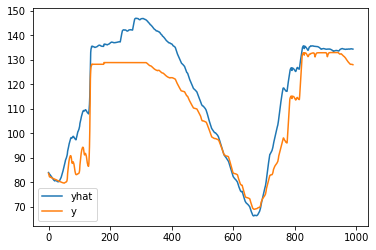

In [138]:
cv_results[['yhat', 'y']].plot()

/opt/homebrew/Caskroom/miniforge/base/envs/hackathon/lib/python3.9/site-packages/prophet/plot.py:539: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])
/opt/homebrew/Caskroom/miniforge/base/envs/hackathon/lib/python3.9/site-packages/prophet/plot.py:540: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])


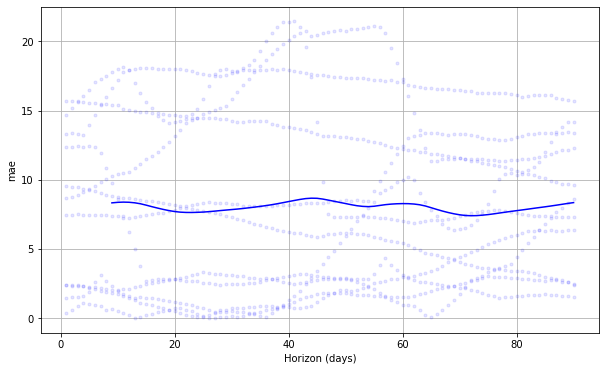

In [139]:
p = plot_cross_validation_metric(cv_results, 'mae')

/opt/homebrew/Caskroom/miniforge/base/envs/hackathon/lib/python3.9/site-packages/prophet/plot.py:539: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])
/opt/homebrew/Caskroom/miniforge/base/envs/hackathon/lib/python3.9/site-packages/prophet/plot.py:540: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])


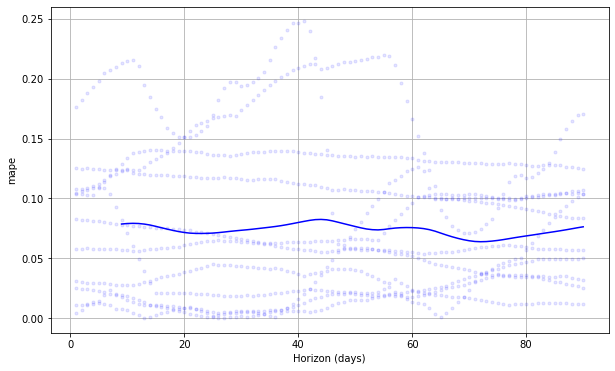

In [140]:
p = plot_cross_validation_metric(cv_results, 'mape')

In [141]:
model5, model5_forecast, model5_fitted, _, _ = train_model(Prophet(yearly_seasonality=10), 
                                                           dummy_data, 
                                                           'FLOW_DATE', 
                                                           'RES_LEVEL_FT', 
                                                           external_regressors=list(dummy_data.drop(columns=['FLOW_DATE', 'RES_LEVEL_FT']).columns.values))

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -5.61722
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       10287.3   0.000455883       442.113      0.4442           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       10288.7   0.000830575       180.365      0.6986      0.6986      228   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       10289.5   0.000934794       181.829           1           1      335   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       10289.6   0.000141533       96.3108      0.4133      0.9419      452   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       10289.6   1.11161e-05       63.7824           1           1      571   
    Iter      log prob        ||dx||      ||grad||       alpha  

In [142]:
model5_fitted.iloc[0, 0] = model5_fitted.iloc[0, 0] + dataset['RES_LEVEL_FT'].values[0]
model5_fitted['Actual'] = model5_fitted['Actual'].cumsum()

model5_fitted.iloc[0, 1] = model5_fitted.iloc[0, 1] + dataset['RES_LEVEL_FT'].values[0]
model5_fitted['Fitted'] = model5_fitted['Fitted'].cumsum()

In [143]:
model5_forecast.iloc[0, 0] = model5_forecast.iloc[0, 0] + model4_fitted.iloc[-1, 0]
model5_forecast['Actual'] = model5_forecast['Actual'].cumsum()

model5_forecast.iloc[0, 1] = model5_forecast.iloc[0, 1] + model4_fitted.iloc[-1, 0]
model5_forecast['Forecasted'] = model5_forecast['Forecasted'].cumsum()

#### Evaluation

##### Train Set

<AxesSubplot:xlabel='FLOW_DATE'>

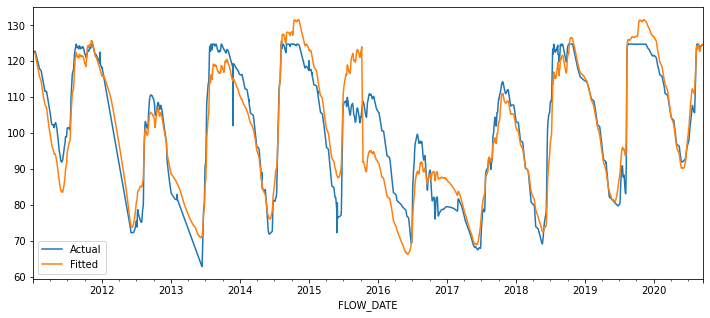

In [144]:
model5_fitted.plot(figsize=(12, 5))

In [145]:
model_evaluation(model5_fitted, mean_absolute_error, 'Fitted', 'Actual')

4.77

In [146]:
model_evaluation(model5_fitted, mean_absolute_percentage_error, 'Fitted', 'Actual')

0.05

##### Test Set

<AxesSubplot:xlabel='FLOW_DATE'>

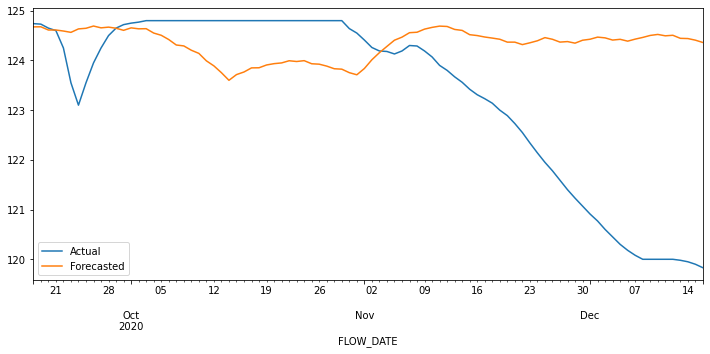

In [147]:
model5_forecast.plot(figsize=(12, 5))

In [148]:
model_evaluation(model5_forecast, mean_absolute_error, 'Forecasted', 'Actual')

1.51

In [149]:
model_evaluation(model5_forecast, mean_absolute_percentage_error, 'Forecasted', 'Actual')

0.01